<a href="https://colab.research.google.com/github/nyw-pathfinder/Deep-Learning-Bootcamp-with-PyTorch/blob/master/Copy_of_04_multinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

- [Multinomial Classification](#multinomial)
- [ReLU](#relu)
- [Adam](#adam)
- [In Pytorch](#pytorch)
- [Exercises](#exercises)


# Housekeeping

- Today we'll extend binomial classification to multinomial classification, and add a few more complications to our activation functions and optimizers
- Some references for today
  - [Official pytorch tutorials](https://pytorch.org/tutorials)
  - [Pytorch tutorials by yunjey, from beginning to advanced](https://github.com/yunjey/pytorch-tutorial)
  - [MIT Intro to Deep Learning lecture video](https://www.youtube.com/watch?v=njKP3FqW3Sk&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=1)
    (overview of machine learning and neural networks)
  - [3blue1brown video on neural networks](https://www.youtube.com/watch?v=aircAruvnKk)
    (for understanding neural network basics)
  - [Deep Feedforward Networks from the Deep Learning Book](https://www.deeplearningbook.org/contents/mlp.html)
    (more advanced intro to NN)
  - [Optimizers Explained](https://mlfromscratch.com/optimizers-explained/#/) for Adam
- Today's url 
  - https://git.io/ml2021-04
- Email if you need help with any of this!

# Multinomial Example: Fisher's Irises <a id="multinomial" />

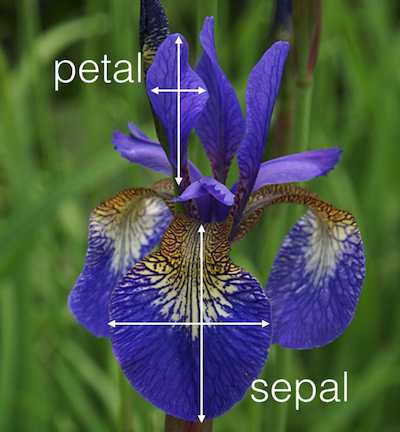

In [ ]:
from IPython.display import Image
Image('iris_petal_sepal.png')

- In what we discussed last week, we only distinguish two classes, what if we have more?
- The iris dataset is a classic classification task, first studied by
  Fisher in 1936. 
- The goal is, given features measured from a particular
  iris, classify it into one of three species:
  - Iris setosa, Iris virginica, or Iris versicolor. 
- The features he used are: Sepal width and length, petal width and
  length (all in cm).

### Fisher's Irises: dataset

Lets view the basic variables we have. Setosa (blue) looks easily
separable by the petal length and width, but versicolor and virginica
are a little tricky.

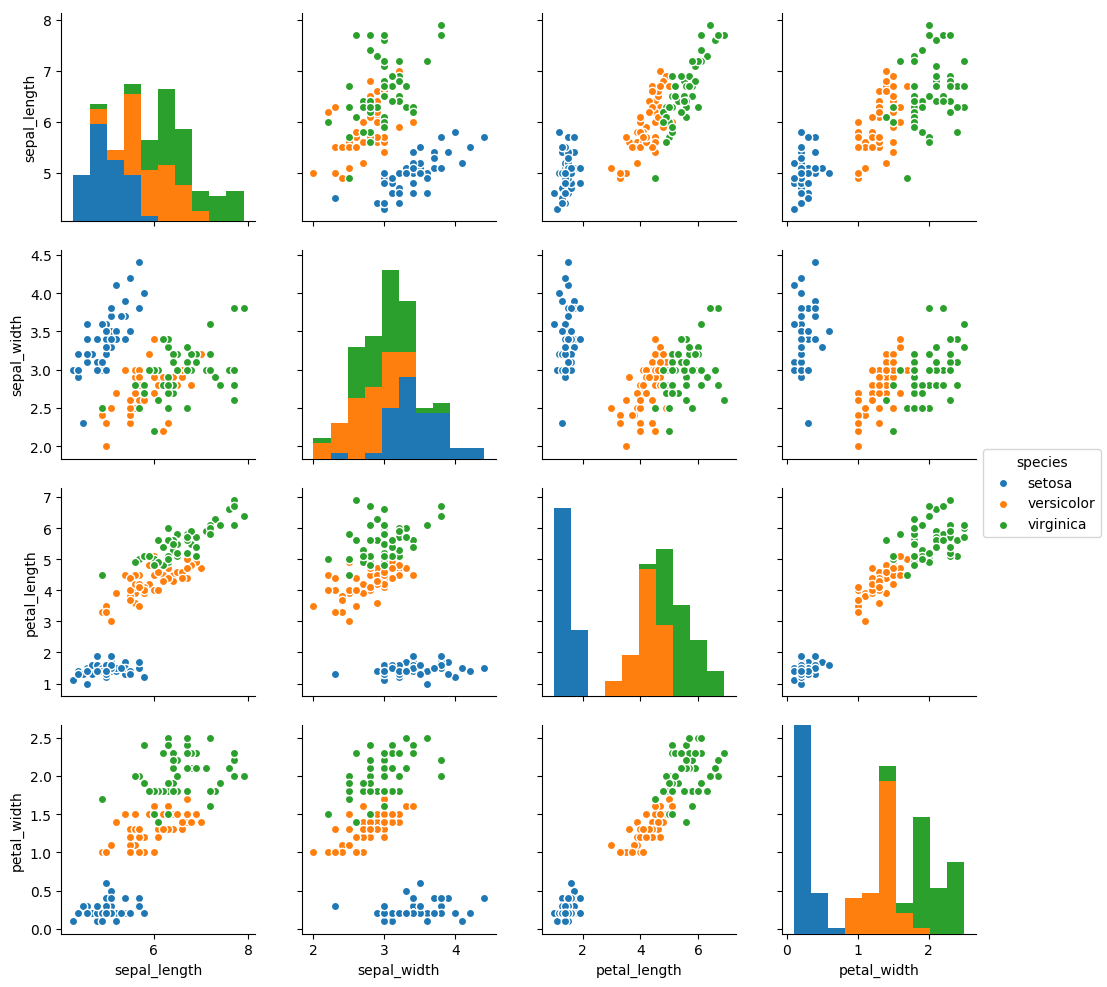

In [ ]:
Image('iris.png')

- We can, however, see that versicolor and virginica could probably be
  separated well by a logistic classifier, but then it will mix up setosa (single turn on curve)
- But, how could we build a classifier to distinguish all 3 categories at once?
  - This is called *multinomial classification* (= multiple-categories)

## Probability Vector and One-hot encoding

We can get the Fisher Iris dataset using `sklearn`:

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt

# check the data format
iris = datasets.load_iris()
print("classes:  ", iris.target_names)
print("features: ", iris.feature_names)
print(f"shape: data:{iris.data.shape}, target:{iris.target.shape}")
print(f"first sample: data{iris.data[0]}, target:{iris.target[0]}")
print(f"last  sample: data{iris.data[-1]}, target:{iris.target[-1]}")

classes:   ['setosa' 'versicolor' 'virginica']
features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
shape: data:(150, 4), target:(150,)
first sample: data[5.1 3.5 1.4 0.2], target:0
last  sample: data[5.9 3.  5.1 1.8], target:2


- We want our classifier able to say which of several categories a
  datapoint belongs to: 0 = setosa, 1 = virginica, 2 = versicolor
- We could label categories by integers, 0, 1, 2, 3, but then how to interpret an output?
  - What would a classifier output of 2.4 mean? Close to 2 but also 3?
    What about 1, its right out?
- Need an alternate way to encode the output
- We will make a vector the size of the number of categories
  - For Fisher's irises, this means a 3-vector
- We require the sum of entries to be 1, and then interpret each entry
  as the probability of belonging to a particular category
  - (0.9, 0.1, 0) is 90% prob. for setosa, 10% virginica, and 0% versicolor
- This relates to a *one-hot encoding*: at truth level everything will
  be 0, except one position representing the true category, which is 1
  - We know our example is setosa, so the y "truth" vector will be (1, 0, 0)
- Given the probability vector, we will interpret the
  highest-probability entry as the prediction of the classifier

Using the colors from above, Fisher's Irises split can be given the following outputs:

<font color="blue">Setosa = [1,0,0]</font>

<font color="orange">Versicolor = [0,1,0]</font>

<font color="green">Virginica = [0,0,1]</font>

## Multinomial Logistic Regression

- Given $k$ non-overlapping categories we will build logistic
  classifiers to build a scheme distinguish all $k$ categories, $P(i)$ for prob. to be cat. $i$
- Build $k-1$ logistic classifiers, comparing category $i$ to
  category $0$ for $i \in [1, 2 \ldots k-1]$, Category 0 is our *reference category*
- This will give $k-1$ $\hat\beta_i$, one for each of the non-reference categories
- The logistic classifiers compare one category against 0 (recall, we build a linear projection $\beta\cdot x$, then pass it through the logistic function $\sigma(x) = 1/(1+e^{-x})$): 
$$P(i|0 \,or\, i) = \frac{1}{1 + e^{-\beta_i \cdot x}}$$ and 
$$P(0|0 \,or\, i) = 1-\frac{1}{1 + e^{-\beta_i \cdot x}} = \frac{e^{-\beta_i \cdot x}}{1 + e^{-\beta_i \cdot x}}$$ so 
$$\frac{P(i|0 \,or\, i)}{P(0|0 \,or\, i)} = e^{\beta_i \cdot x}$$
  - Introduce the requirement that in the full joint-classifier, this probability ratio must still hold, i.e. $P(i)/P(0) = e^{\beta_i \cdot x}$ (where we dropped the conditional)
- So, joining together all the non-reference categories (i.e. taking the above requirement but allowing for any category):
  - $P(1) = P(0) e^{\beta_1 \cdot x}$, $P(2) = P(0) e^{\beta_2 \cdot x}$, ..., $P(k) = P(0) e^{\beta_k \cdot x}$
- We also have the requirement that the probability must sum to 1
  - $P(0) + P(1) + \ldots + P(k-1) = 1$
- Thus, for the reference $P(0) = 1 - \sum_{i \neq 0} P(i) = 1 - P(0) \sum_{i \neq 0} e^{\beta_i \cdot x}$
- Rearranging gives $P(0) = \frac{1}{1 + \sum_{i \neq 0} e^{\beta_i \cdot x}}$, and therefore $P(i) = \frac{e^{\beta_i \cdot x}}{1 + \sum_{j \neq 0} e^{\beta_j \cdot x}}$
- So, if we train logistic classifiers to distinguish one category
  against the reference, we can join them all together to form a
  $k$-category classifier
  - This is called *multinomial logistic regression*

## Softmax Function

- Look at the result of the last page:
  - $P(0) = \frac{1}{1 + \sum_{i \neq 0} e^{\beta_i \cdot x}}$,
    and $P(i) = \frac{e^{\beta_i \cdot x}}{1 + \sum_{j \neq
    0} e^{\beta_j \cdot x}}$ for $i \neq 0$
- We can see that the difference between our reference category and
  the others, is that the reference is weighted as 1, the others get
  weighted as $e^{\beta_j \cdot x}$
- We can symmetrize and remove the reference by giving it the same
  weight as the others, i.e. introducing a $\beta_0$ for the 0 category, so that $1 \to e^{\beta_0\cdot x}$
- The result is that $$P(i) = \frac{e^{\beta_i \cdot x}}{\sum_{j} e^{\beta_j \cdot x}}$$ for all $i$
- Now, the $\beta_i \cdot x$ term came from the fact we were using logistic regression
- We can drop the requirement and consider an arbitrary network upstream, giving $z_i$ at the output layer, then we have $$\mathrm{softmax}(\vec z)_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$ for all $i$
  - We call this the "softmax" function, we see its basically the generalization of the sigmoid function to k categories
  - This makes everything look nicer, but we do lose the intuitive idea of this just being $k-1$ logistic classifiers
- It keeps the nice property that $\sum P(i) = 1$, so that we can
  still interpret $P(i)$ as "the probability" for the datapoint to
  be in category $i$
- Aside: you should also be able to see that this is just the
  Boltzmann distribution, with $-z_i$ being the "energy of state $i$" (if not, refresh your thermodynamics)

# Cross-Entropy Loss

- Last week we looked at binary cross-entropy, and derived
$$BCELoss =  - \sum_i y_i \log p_i + (1-y_i)\log (1-p_i)$$
- When we have more categories, we use the one-hot encoding scheme, and we can simply extend the BCELoss to CrossEntropyLoss
- Similar to the softmax function above, we can generalize:
  - If the input $x$ has a known, labelled output of category c, then the loss should be $\log p_c$ where $p_c$ is the network probability for category $c$ given input $x$: $p_c = p(c|x)$
  - For the binary case, this gives the same as the BCE since $p_1 = p$, and $p_0 = 1 - p$, so we will pick out the right terms
  - In general, as in the binary case, the loss is penalizing more, the more certain the network thinks the output doesn't belong to the right category
- For a batch, we can write this: $$\mathrm{CrossEntropyLoss} = - \sum_i y_{i} \log p(y_i | x_i)$$ for all datapoints $x_i$ with label $y_i$


# ReLU (Rectified Linear Unit) Activation

$ReLU(x) = \begin{array}{cc}
   \{ & 
    \begin{array}{cc}
      0 & x\leq 0 \\
      x & x\gt 100
    \end{array}
\end{array} $

- In order for our neural networks to be able to model arbitrary spaces, we need to have some nonlinearity, which we introduce with the *activation* functions
  - The connections between layers are all linear functions
- We've been using sigmoid or tanh until now, but they have an issue with *saturation*
  - Recall, the weights learn to model the data better by following the gradient down the loss landscape
  - If the weights get too big, then any data will send the node to large values, so the output is either 0 or 1, with a gradient of 0, so it can never learn a forward mapping
- One of the most straightforward way to introduce nonlinearity is the *ReLU* function, which is 0 below 0, and x above x
  - So, almost linear (note that in the universal approximation, we said the activation function should be bounded, but a network with ReLU can be shown to also work as a universal, since you can easily make a "linear turn on curve" with 2 ReLU nodes slightly offset)
- In practice, using ReLU is very performant for neural networks, as the gradients are always either 0 or 1
  - So long as some datapoints activate the node (i.e. the bias is not out of range of all datapoints), it can always learn

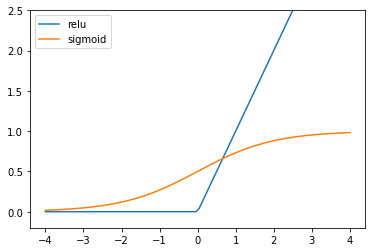

In [ ]:
import numpy as np; import matplotlib.pyplot as plt
x = np.linspace(-4, 4, 100)
y = np.array(x)
y[x<0] = 0
plt.plot(x, y, label='relu')
plt.plot(x, 1./(1+np.exp(-x)), label='sigmoid')
plt.ylim(-0.2,2.5)
plt.legend()

# Adam <a id="adam" />

- We'll look the last complication we'll add to our optimizers by seeing where the *Adam* (ADAptive Momentum) optimizer comes from
- Last week we looked at adding momentum into the SGD optimizer, so the SGD could follow an average path
- The momentum term was added equally to all the parameters, with $\gamma$ controlling the relative rate of the momentum and the current gradient, and the learning rate $\eta$ telling the (uniform) step size:
$$v_t = \gamma v_{t-1} + \nabla_\theta L(\theta)$$
$$\theta_t = \theta_{t-1} - \eta v_t$$
- A simple extension to this idea is to use Adaptive Gradients: AdaGrad
  - We keep track of the square of the size of each gradient: $$s_{t,i} = s_{t-1,i} + \left ( \nabla_{\theta_i} L(\theta) \right ) ^2$$ [note that here we square each component of the gradient individually, $s_t$ is still a vector, with one entry for each $\theta_i$]
  - When we update, we reduce the learning rate by the running sum: $$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{\epsilon + s_t}} \nabla_{\theta_i} L(\theta)$$ ($\epsilon$ is added to stabilize the division)
  - This decreases the learning rate over time, with the decrease adaptive to each parameter, in proportion to the size of the gradient (the larger the gradients, the faster it will decay)
  - In general, when optimizing, we want to start with big steps (high learning rate), and gradually make them smaller as we approach closer to the minimum
  - We assume large gradients are speeding us down a hill, so we avoid overstepping the minima by turning the learning rate down
  - AdaGrad gives us a way to do this without needing to create a learning rate schedule ourselves, it adapts to the size of the gradients
- One issue with AdaGrad leads us to RMSprop
  - With AdaGrad, the learning rate will *always* decrease, eventually the $s$ term will overwhelm $\eta$ and the network will stop learning, even if its not reached a minima
  - To get RMSprop, we simply decay the gradient sum as we go using a momentum factor $\gamma$: $$s_{t,i} = \gamma s_{t-1,i} + (1-\gamma) (\nabla_{\theta_i} L(\theta))^2$$ and use the same update as above
  - We are still adapting the learning rate for each parameter, but instead of slowly freezing out all the parameters, if they stop learning, the gradient scale will decay away, so that the learning rate will increase again
- Adam combines the adaptive learning rate above with the momentum from last week (using the variables from the [original paper](https://arxiv.org/pdf/1412.6980v9.pdf))
$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) (\nabla_\theta L(\theta))$$
$$v_{t,i} = \beta_2 s_{t-1,i} + (1 - \beta_2) (\nabla_{\theta_i} L(\theta))^2$$
$$\hat{m_t} = \frac{m_t}{1 - \beta^t_1}$$
$$\hat{v_t} = \frac{v_t}{1 - \beta^t_2}$$
$$\theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v_t}} + \epsilon} \hat{m_t}$$
- We have independent decay rates for the momentum $\beta_1$, and the adaptive learning rate $\beta_2$, by defaul in pytorch $\beta_1=0.9, \beta_2=0.999$
- The hat terms were introduced in the paper to bound the step size, they show that (with a few assumption), that the effective step size will stay around $\eta$
- In pytorch, `torch.optim.Adam` can be used instead of `torch.optim.SGD`, use `Adam(..., betas=(beta1,beta2))` to change the value of the $\beta$s
  - There is also `torch.optim.AdaGrad`, and `torch.optim.RMSprop` if you would like to try them also

# In PyTorch <a id="pytorch" />

- There are some subtleties in PyTorch
- `torch.nn.CrossEntropyLoss()` creates the loss function
  - It applies the softmax inside the loss function, so *don't* apply softmax in your network if you use `CrossEntropyLoss`
  - That is, pytorch is calculating: $$\mathrm{CrossEntropyLoss} = - \log \frac{e^{z_i}}{\sum_j e^{z_j}} = -z_i + \log \sum_j e^{z_j}$$ when told the given datapoint with final layer output $\vec z$ is labelled by $i$
  - If you want to apply softmax yourself, you should use `NLLLoss` instead 
  - However, its generally not necessary if you are just interested in finding the most-likely category, as the softmax function preserves ordering (higher values before softmax will be higher after softmax, it just squashes the values to the range [0,1]), so the highest output value before softmax is the same as the highest after softmax, with much less computation!
  - The output you pass in should be the *position* of the true value in the output vector (i.e. don't pass `[0,0,0,1,0]`, pass in `3` as the truth label)


In [30]:
from sklearn import datasets
import matplotlib.pyplot as plt

# check the data format
iris = datasets.load_iris()
print(f"shape: data:{iris.data.shape}, target:{iris.target.shape}")
print(f"first sample: data{iris.data[0]}, target:{iris.target[0]}")
print(f"last  sample: data{iris.data[-1]}, target:{iris.target[-1]}")


shape: data:(150, 4), target:(150,)
first sample: data[5.1 3.5 1.4 0.2], target:0
last  sample: data[5.9 3.  5.1 1.8], target:2


In [31]:
# okay, it looks like its in the form we want, lets make a network
import torch as th
class FisherNet(th.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = th.nn.Linear(4,512)
        self.fc2 = th.nn.Linear(512,3)
    def forward(self, x):
        x = self.fc1(x)
        x = th.relu(x)
        x = self.fc2(x)
        return x # we will use CrossEntropyLoss, so *dont* softmax here

net = FisherNet()
x = th.tensor(iris.data).float()
print(type(x))

y = th.tensor(iris.target)
output = net(x)


# print("shape")
print(output.shape)
print(y.shape) # check it works as expected
# print("network outputs")
# print(output[0]) # check the (untrained) outputs
# print(output[1])
# # how would it look after softmax? check that before and after, the ordering is preserved
# print("after softmax")
# print(th.softmax(output[0],0)) # softmax needs to know which dimension to sum across, here theres only 1 그리고 0차원
# print(th.softmax(output[1],0))
# # softmax sum per datapoint
# print("check sum")
# print(th.softmax(output,1)[:5].sum(axis=1)) # check the outputs sum exactly to 1 in a couple of cases


print(th.softmax(output,0)[:5])
print(th.softmax(output,0)[:5].shape) #150개 칼럼 더하면 1 나온다 이넘아
print(th.softmax(output,0)[:5].sum())
print(th.softmax(output,1)[:5])
print(th.softmax(output,1).shape)
# print(th.softmax(output,1)[:150])


<class 'torch.Tensor'>
torch.Size([150, 3])
torch.Size([150])
tensor([[0.0060, 0.0115, 0.0070],
        [0.0057, 0.0112, 0.0073],
        [0.0058, 0.0110, 0.0073],
        [0.0058, 0.0101, 0.0072],
        [0.0060, 0.0113, 0.0070]], grad_fn=<SliceBackward>)
torch.Size([5, 3])
tensor(0.1202, grad_fn=<SumBackward0>)
tensor([[0.4269, 0.4086, 0.1645],
        [0.4163, 0.4069, 0.1768],
        [0.4226, 0.4015, 0.1759],
        [0.4369, 0.3825, 0.1806],
        [0.4336, 0.4021, 0.1643]], grad_fn=<SliceBackward>)
torch.Size([150, 3])


In [33]:
# now run a training loop
from collections import defaultdict
opt = th.optim.Adam(net.parameters(), lr=1e-2)
los = th.nn.CrossEntropyLoss()
bs = 25
net(x)
print(net(x).shape)
for e in range(1,11):
    eloss = defaultdict(lambda: [])
    for idx in range(0,150,bs):
        opt.zero_grad()
        p = net(x[idx:idx+bs])
        loss = los(p, y[idx:idx+bs])
        loss.backward()
        opt.step()
        # keep track of some summary statistics
        eloss['loss'].append(loss.item())
        eloss['n'].append(x[idx:idx+bs].size(0))
        eloss['corr'].append(sum(p.max(axis=1)[1] == y[idx:idx+bs]))
    print(f'epoch {e:3d} avg loss; {sum(eloss["loss"])/sum(eloss["n"]):.4f}') #d는 딕셔너리에서 3번째.문자열에서 특정 부분만 바꾸고 나머지 부분은 일정하게 할때. 사용
    print(f'          acc.;     {sum(eloss["corr"])/sum(eloss["n"]):.4f}')
print("done")
print(f"Final accuracy: {sum(net(x).max(axis=1)[1] == y) / 150.:.4f}")

torch.Size([150, 3])
epoch   1 avg loss; 0.0414
          acc.;     0.5533
epoch   2 avg loss; 0.0671
          acc.;     0.6667
epoch   3 avg loss; 0.0223
          acc.;     0.7267
epoch   4 avg loss; 0.0112
          acc.;     0.8133
epoch   5 avg loss; 0.0104
          acc.;     0.8600
epoch   6 avg loss; 0.0078
          acc.;     0.9000
epoch   7 avg loss; 0.0047
          acc.;     0.9667
epoch   8 avg loss; 0.0053
          acc.;     0.9600
epoch   9 avg loss; 0.0053
          acc.;     0.9467
epoch  10 avg loss; 0.0043
          acc.;     0.9733
done
Final accuracy: 0.9800


## Confusion Matrix

Now, we can find the *confusion matrix* of the classifier. That is the matrix showing how the network labelled each category. Each row represents one true category, and the columns show the number of entries the network gave the highest output in that category. Diagonal entries therefore represent the correctly classified case, off-diagonal are the number it incorrectly classified. Below you can see the confusion matrix for our Fisher Iris network, the network has confused some of the virginica as versicolor. If you look back at the 2d plots, you can see these are exactly the overlapping samples we were worried about initially. The network hasn't been able to disentangle the two categories from the data.

Note, here we have the same number of entries in each class. If you have a dataset with differing numbers of entries per class, you might want to normalize each *row* to 1, to get a better understanding of the classifier performance per class.

[Text(0, 0, 'setosa'), Text(0, 1, 'versicolor'), Text(0, 2, 'virginica')]

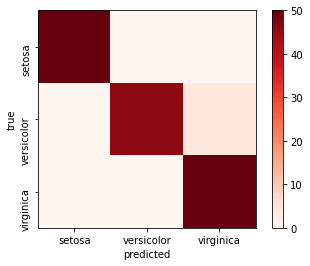

In [ ]:
import numpy as np
predictions = net(x).max(axis=1)[1]
confusion = np.zeros((3,3))
for pred, true in zip(predictions, y):
    confusion[true,pred] += 1 # fills [y,x]
    
plt.imshow(confusion, cmap='Reds'); plt.colorbar()
plt.xlabel('predicted'); plt.ylabel('true')
plt.gca().set_xticks([0,1,2])
plt.gca().set_yticks([0,1,2])
# Set ticks labels to the category names:
plt.gca().set_xticklabels(iris.target_names)
plt.gca().set_yticklabels(iris.target_names, rotation='vertical')

# Exercises <a id="exercises" />

We will build an MLP classifier for the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

It has 60,000 28x28 images as inputs, and 10 categories of outputs.
Torchvision is a handy library for computer vision tasks (like classifying images), which contains a helpful set of common datasets for easy download. 

Run the cell below to download the data. `torch.utils.data.DataLoader` can simplify running a training loop. With it, you can run a batch using `for x,y in train:` where now `x` will be a batch of inputs with `y` the corresponding outputs of the whole batch.

Change '/data/MNIST' to a directory you can write to (for example, the current directory '.')
On gate, I have already downloaded it, and you can use "/hdfs/user/iawatson/datasets"

In [1]:
import torch as th
import torchvision as tv

train = tv.datasets.FashionMNIST('/data/MNIST', download=True, train=True, transform=tv.transforms.ToTensor())
train_data = th.utils.data.DataLoader(train, batch_size=512)
test = tv.datasets.FashionMNIST('/data/MNIST', download=True, train=False, transform=tv.transforms.ToTensor())
test_data = th.utils.data.DataLoader(test, batch_size=512)


Extracting /data/MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/FashionMNIST/raw




Extracting /data/MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/FashionMNIST/raw




Extracting /data/MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/FashionMNIST/raw




Extracting /data/MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# check the output of a batch
x,y = next(iter(train_data))
x.shape, y.shape, y[0], y.max(), y.min()


(torch.Size([512, 1, 28, 28]),
 torch.Size([512]),
 tensor(9),
 tensor(9),
 tensor(0))

Draw the first few images with `plt.imshow` and check the category they belong to. Does it look right? (i.e. do the images look like they belong to the given categories). Check the link above for the categories.

In [25]:
import matplotlib.pyplot as plt
import numpy as np

x_train, y_train = next(iter(train_data)) #iter로 data를 부르는게 중요하다. inter하고 next 확인하기/  하나씩 해야 index 차원이 안 넘어간다. x는 이미지 y 0에서 9까지 카테고리 근데 왜 다 0000이냐 이미지인데.
print(x_train.shape)
print(y_train.shape)

# fig, ax = plt.subplots(5,5)
# fig.set_size_inches((20,14))
# for i in range(5):
#     for j in range(5):
#         idx = np.random.randint(512) #512개로 나눈다는 의미인가. 이미지가 60,000개로 알고있는데...
#         ax[i][j].imshow(x_train[idx,0,:])
        # # ax[i][j].set_xlabel(label[y_train[idx].item()])
        # ax[i][j].set_xticklabels([]) 이것들은 x축 y축 내용 바꾸는 함수
        # ax[i][j].set_yticklabels([])

torch.Size([512, 1, 28, 28])
torch.Size([512])


Create a neural network which can classify the Fashion MNIST images. Try various network architectures, and hidden layer sizes. In you training loop, keep track of the average batch loss for the training set, and also the test set. You use this information to make sure your network is still learning as you are running.

In [45]:
class FisherNet(th.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = th.nn.Linear(28,128)
        self.fc2 = th.nn.Linear(128,32)
        self.fc3 = th.nn.Linear(32,10)
    def forward(self, x):
        x = self.fc1(x)
        x = th.relu(x)
        x = self.fc2(x)
        x = th.relu(x)
        x = self.fc3(x)
        print(x.shape)

        return x # we will use CrossEntropyLoss, so *dont* softmax here

net = FisherNet()
# x = th.tensor(x_train)
# y = th.tensor(y_train)

output = net(x_train)
print(output.shape)

from collections import defaultdict
opt = th.optim.Adam(net.parameters(), lr=1e-2)
los = th.nn.CrossEntropyLoss()
bs = 16


for e in range(1,11):
    eloss = defaultdict(lambda: [])
    for idx in range(0,512,16):
        opt.zero_grad()
        p = net(x[idx:idx+bs])
        print(p.shape)
        loss = los(p, y[idx:idx+bs])
        loss.backward()
        opt.step()
        # keep track of some summary statistics
        # eloss['loss'].append(loss.item())
        # eloss['n'].append(x[idx:idx+bs].size(0))
        # eloss['corr'].append(sum(p.max(axis=1)[1] == y[idx:idx+bs]))
#     print(f'epoch {e:3d} avg loss; {sum(eloss["loss"])/sum(eloss["n"]):.4f}') #d는 딕셔너리에서 3번째.문자열에서 특정 부분만 바꾸고 나머지 부분은 일정하게 할때. 사용
#     print(f'          acc.;     {sum(eloss["corr"])/sum(eloss["n"]):.4f}')
# print("done")
# print(f"Final accuracy: {sum(net(x).max(axis=1)[1] == y) / 150.:.4f}")

torch.Size([512, 1, 28, 10])
torch.Size([512, 1, 28, 10])


RuntimeError: ignored

Now draw the *confusion matrix* of your classifier over the test set. Check the fashion mnist link above to find out which categories are being confused the most. Does it make sense that the network would confuse them?

Now try the [KMNIST dataset](https://github.com/rois-codh/kmnist). The goal here is to classify 28x28 black and white images of handdrawn hiragana into the 49 classes. The data is more complex and there are more categories, so the network will need to increase in size to give a nice result. As before, start by drawing a few examples. Then make a network (more complicated this time! maybe add another layer, or increase the number of nodes (don't be afraid to really push the GPU!)), keep track of the losses to check the network is still learning, and then check the confusion matrix.

As before, if you're using gate, the data is available if you change '/data/torchvision' to '/hdfs/user/iawatson/datasets'

In [ ]:
import torch as th
import torchvision as tv

batch_size=512
train = tv.datasets.KMNIST('/data/torchvision', download=True, train=True, transform=tv.transforms.ToTensor())
test = tv.datasets.KMNIST('/data/torchvision', download=True, train=False, transform=tv.transforms.ToTensor())
train = th.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=6)
test = th.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=6)